## Operation NextNest

The goal of this project is to use U.S. Census Data to help me find a new neighborhood that's close to SAS Campus HQ in Cary, North Carolina.  We'll use Census Block Group data and optimization procedures to create a list of ideal target neighborhoods that are no more than a 30 minutes drive from campsus.

Tools used in this analysis are Python and SAS.

### Prepare Packages

In [3]:
# Load the Census Bureau Package
!pip install censusdata

# Load other important packages
!pip install geopandas matplotlib geopy osmnx swat sas7bdat pyunpack patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 6.0 MB/s eta 0:00:00


In [2]:
# Load the packages
import censusdata
import pandas as pd
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import swat
import matplotlib.pyplot as plt
import sas7bdat

from geopy.distance import geodesic

## Unzip Data on GitHub

In [4]:
from pyunpack import Archive
import os

# Define the path to the zipx file and the output directory
zipx_file = "tl_2023_37_bg.shp.zipx"
output_directory = os.getcwd()  # Use the current working directory

# Extract the contents
try:
    Archive(zipx_file).extractall(output_directory)
    print(f"Extracted files to {output_directory}")
except Exception as e:
    print(f"An error occurred: {e}")

Extracted files to /home/jovyan/OperationNextNest


### Import Census Block Group Data

In [5]:
# Specify FIPS codes for North Carolina, Wake, and Durham Counties
state = '37'  # North Carolina
wake_county = '183'  # Wake County
durham_county = '063'  # Durham County

In [6]:
# Define block group-level variables to retrieve ==> https://api.census.gov/data/2021/acs/acs5/variables.html
variables = [
    'B01001_003E',  # Male under 5 years
    'B01001_027E',  # Female under 5 years
    'B01003_001E',  # Total population
    'B11003_003E',  # Family households with children under 6 years
    'B11001_002E',  # Total family households
    'B11003_002E',  # Households with children under 18
    'B11004_002E',  # Married-couple family households
    'B11004_004E',  # Married-couple family households with children under 6 years
    'B19013_001E',  # Median household income
    'B25064_001E',  # Median gross rent
    'B25088_002E',  # Median selected monthly owner costs (with mortgage)
    'B25077_001E',  # Median housing value
    'B25034_001E',  # Median year structure built
    'B25002_003E',  # Vacant housing units
    'B14003_003E',  # Nursery school enrollment
    'B14003_004E',  # Kindergarten enrollment
    'B15003_017E',  # Educational attainment (some college)
    'B15003_022E',  # Educational attainment (bachelor's degree or higher)
    'B08013_001E',  # Mean travel time to work
    'B25044_003E'   # Households with no vehicle
]

In [7]:
# Download data for block groups in Wake County
wake_data = censusdata.download('acs5', 2021,
                                censusdata.censusgeo([('state', state), ('county', wake_county), ('block group', '*')]),
                                variables)

In [8]:
##################################################  Need to add GEOID for upcoming merge 

# Reset the index to access the geographic descriptors
wake_data = wake_data.reset_index()

# Check the structure of the 'index' column
print(wake_data['index'].head())

# Extract the GEOID from the index
# The 'index' column includes a hierarchy of geographic identifiers; we need the full GEOID.
wake_data['GEOID'] = wake_data['index'].apply(lambda x: 
    x.geo[0][1].zfill(2) + 
    x.geo[1][1].zfill(3) + 
    x.geo[2][1].zfill(6) + 
    x.geo[3][1].zfill(1)
)

# Drop the 'index' column to clean up
wake_data = wake_data.drop(columns=['index'])

# Display the resulting DataFrame with GEOID
print(wake_data.head())

0    Block Group 1, Census Tract 501, Wake County, ...
1    Block Group 2, Census Tract 501, Wake County, ...
2    Block Group 3, Census Tract 501, Wake County, ...
3    Block Group 1, Census Tract 503, Wake County, ...
4    Block Group 2, Census Tract 503, Wake County, ...
Name: index, dtype: object
   B01001_003E  B01001_027E  B01003_001E  B11003_003E  B11001_002E  \
0           31           25         1203           45          145   
1            9           22         2874           18          285   
2            0            0         1110            0          134   
3            0           17         1723           73          250   
4            0            0          605            0           35   

   B11003_002E  B11004_002E  B11004_004E  B19013_001E  B25064_001E  ...  \
0          134          134           22        97917         1238  ...   
1          265          265            8       101058         1788  ...   
2          107          107            0       10919

In [9]:
# Download data for block groups in Durham County
durham_data = censusdata.download('acs5', 2021,
                                  censusdata.censusgeo([('state', state), ('county', durham_county), ('block group', '*')]),
                                  variables)

In [10]:
# Reset the index to access the geographic descriptors
durham_data = durham_data.reset_index()

# Extract GEOID components from the geography index and ensure 12-digit format
durham_data['GEOID'] = durham_data['index'].apply(lambda x: 
    x.geo[0][1].zfill(2) +  # State FIPS (2 digits)
    x.geo[1][1].zfill(3) +  # County FIPS (3 digits)
    x.geo[2][1].zfill(6) +  # Tract Code (6 digits)
    x.geo[3][1].zfill(1)    # Block Group Code (1 digit)
)

# Drop the 'index' column to clean up
durham_data = durham_data.drop(columns=['index'])

# Display the resulting DataFrame with GEOID
print(durham_data.head())


   B01001_003E  B01001_027E  B01003_001E  B11003_003E  B11001_002E  \
0          108           26         1193           83          284   
1            8           98         2727           65          676   
2           71           57         1807          187          431   
3            0           32          759           40          181   
4            5            4          603           39          164   

   B11003_002E  B11004_002E  B11004_004E  B19013_001E  B25064_001E  ...  \
0          179          179           74        76482          964  ...   
1          444          444            8        74167          741  ...   
2          264          264           15        39327          928  ...   
3          146          146           40        65469         1263  ...   
4          140          140            4        56042         1178  ...   

   B25077_001E  B25034_001E  B25002_003E  B14003_003E B14003_004E B15003_017E  \
0       197400          569           24       

In [11]:
# Combine data for both counties
census_blockgroup_data = pd.concat([wake_data, durham_data])

In [12]:
# Display the updated data
print(census_blockgroup_data.head())

   B01001_003E  B01001_027E  B01003_001E  B11003_003E  B11001_002E  \
0           31           25         1203           45          145   
1            9           22         2874           18          285   
2            0            0         1110            0          134   
3            0           17         1723           73          250   
4            0            0          605            0           35   

   B11003_002E  B11004_002E  B11004_004E  B19013_001E  B25064_001E  ...  \
0          134          134           22        97917         1238  ...   
1          265          265            8       101058         1788  ...   
2          107          107            0       109196         1778  ...   
3          230          230           18        67536          996  ...   
4           31           31            0        72083         1259  ...   

   B25077_001E  B25034_001E  B25002_003E  B14003_003E B14003_004E B15003_017E  \
0       504600          664           78       

In [13]:
# Rename columns for clarity
census_blockgroup_data.columns = [
    'Male under 5', 'Female under 5', 'Total Population', 'Households with Children under 6', 
    'Total Family Households', 'Households with Children under 18', 
    'Married-couple Households', 'Married-couple with Children under 6', 
    'Median Household Income', 'Median Gross Rent', 'Monthly Owner Costs (with mortgage)', 
    'Median Housing Value', 'Median Year Structure Built', 'Vacant Housing Units', 
    'Nursery School Enrollment', 'Kindergarten Enrollment', 'Some College', 
    'Bachelor’s Degree or Higher', 'Mean Travel Time to Work', 'Households with No Vehicle',"GEOID"
]

In [14]:
# Calculate percentages
census_blockgroup_data['Children under 5'] = census_blockgroup_data['Male under 5'] + census_blockgroup_data['Female under 5']
census_blockgroup_data['% Children under 5'] = census_blockgroup_data['Children under 5'] / census_blockgroup_data['Total Population'] * 100
census_blockgroup_data['% Households with Children under 6'] = census_blockgroup_data['Households with Children under 6'] / census_blockgroup_data['Total Family Households'] * 100
census_blockgroup_data['% Married-couple Households'] = census_blockgroup_data['Married-couple Households'] / census_blockgroup_data['Total Family Households'] * 100
census_blockgroup_data['% Married-couple with Children under 6'] = census_blockgroup_data['Married-couple with Children under 6'] / census_blockgroup_data['Total Family Households'] * 100


In [15]:
# Display the updated data
print(census_blockgroup_data.head())

   Male under 5  Female under 5  Total Population  \
0            31              25              1203   
1             9              22              2874   
2             0               0              1110   
3             0              17              1723   
4             0               0               605   

   Households with Children under 6  Total Family Households  \
0                                45                      145   
1                                18                      285   
2                                 0                      134   
3                                73                      250   
4                                 0                       35   

   Households with Children under 18  Married-couple Households  \
0                                134                        134   
1                                265                        265   
2                                107                        107   
3                           

### Prepare the Data for Mapping

In [16]:
# Path to the block group shapefile for North Carolina
shapefile_path = './tl_2023_37_bg.shp'

In [17]:
# Load the block group shapefile with GeoPandas
gdf = gpd.read_file(shapefile_path)

In [18]:
# Display the first few rows
print(gdf.columns)

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'GEOIDFQ',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'geometry'],
      dtype='object')


In [19]:
# Filter for Wake and Durham Counties using the county FIPS codes
gdf = gdf[gdf['COUNTYFP'].isin(['183', '063'])]

In [20]:
# Check the GeoDataFrame structure
print(gdf.head())

   STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID                GEOIDFQ  \
92      37      063  002019        1  370630020191  1500000US370630020191   
93      37      063  002020        1  370630020201  1500000US370630020201   
94      37      063  001806        1  370630018061  1500000US370630018061   
95      37      063  001808        2  370630018082  1500000US370630018082   
96      37      063  002024        1  370630020241  1500000US370630020241   

         NAMELSAD  MTFCC FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
92  Block Group 1  G5030        S  4885136   51127  +35.9033751  -078.9763406   
93  Block Group 1  G5030        S  7053910  190334  +35.8836714  -078.9598590   
94  Block Group 1  G5030        S  3377611   93260  +36.0054078  -078.8097880   
95  Block Group 2  G5030        S  4429008   16941  +35.9626638  -078.8290804   
96  Block Group 1  G5030        S   586893       0  +35.9250081  -078.9415460   

                                             geome

In [21]:
# Merge the Census data with the shapefile GeoDataFrame
# Assuming 'GEOID' is the common identifier for merging

# Ensure GEOID in gdf is a string
gdf['GEOID'] = gdf['GEOID'].astype(str)

# Ensure GEOID in census_blockgroup_data is a string
census_blockgroup_data['GEOID'] = census_blockgroup_data['GEOID'].astype(str)

In [22]:
merged_gdf = gdf.merge(census_blockgroup_data, on='GEOID')

In [23]:
# Check the result
print(merged_gdf.head())

  STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID                GEOIDFQ  \
0      37      063  002019        1  370630020191  1500000US370630020191   
1      37      063  002020        1  370630020201  1500000US370630020201   
2      37      063  001806        1  370630018061  1500000US370630018061   
3      37      063  001808        2  370630018082  1500000US370630018082   
4      37      063  002024        1  370630020241  1500000US370630020241   

        NAMELSAD  MTFCC FUNCSTAT    ALAND  ...  Kindergarten Enrollment  \
0  Block Group 1  G5030        S  4885136  ...                     None   
1  Block Group 1  G5030        S  7053910  ...                     None   
2  Block Group 1  G5030        S  3377611  ...                     None   
3  Block Group 2  G5030        S  4429008  ...                     None   
4  Block Group 1  G5030        S   586893  ...                     None   

  Some College Bachelor’s Degree or Higher Mean Travel Time to Work  \
0          155       

### Plot the Data

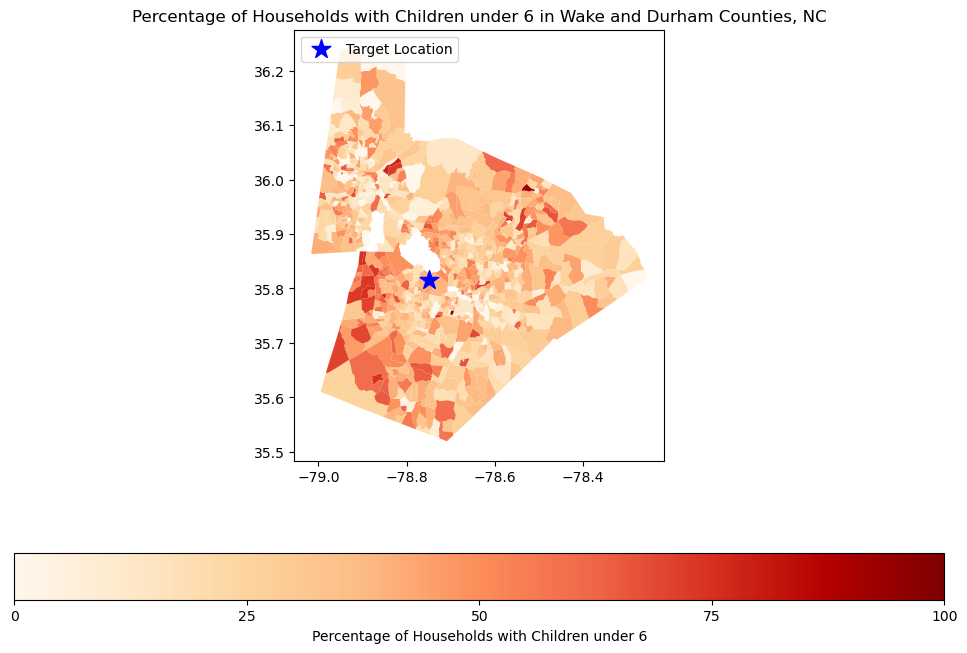

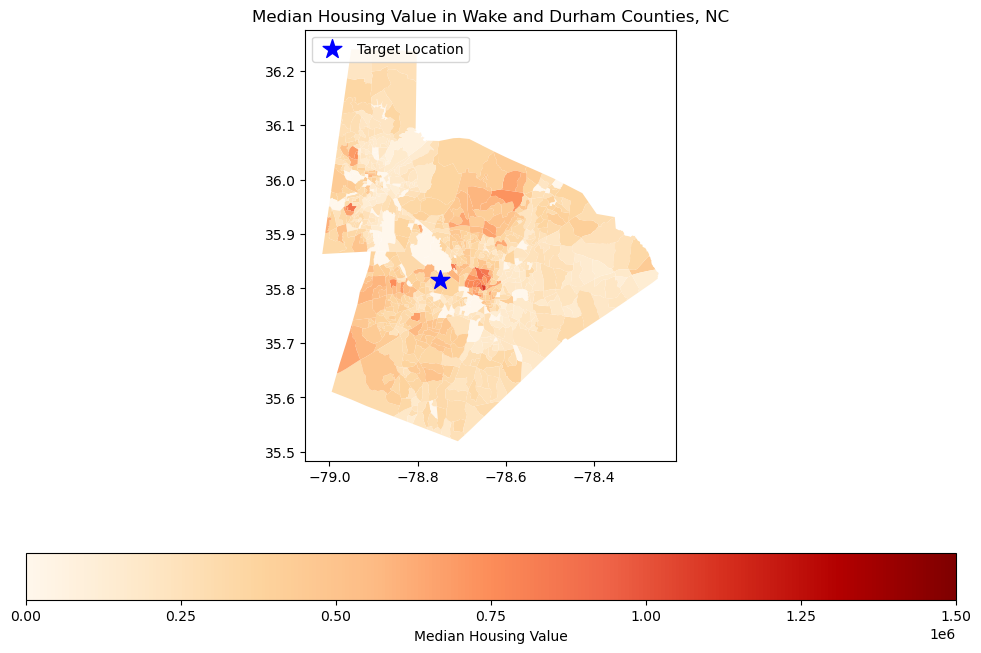

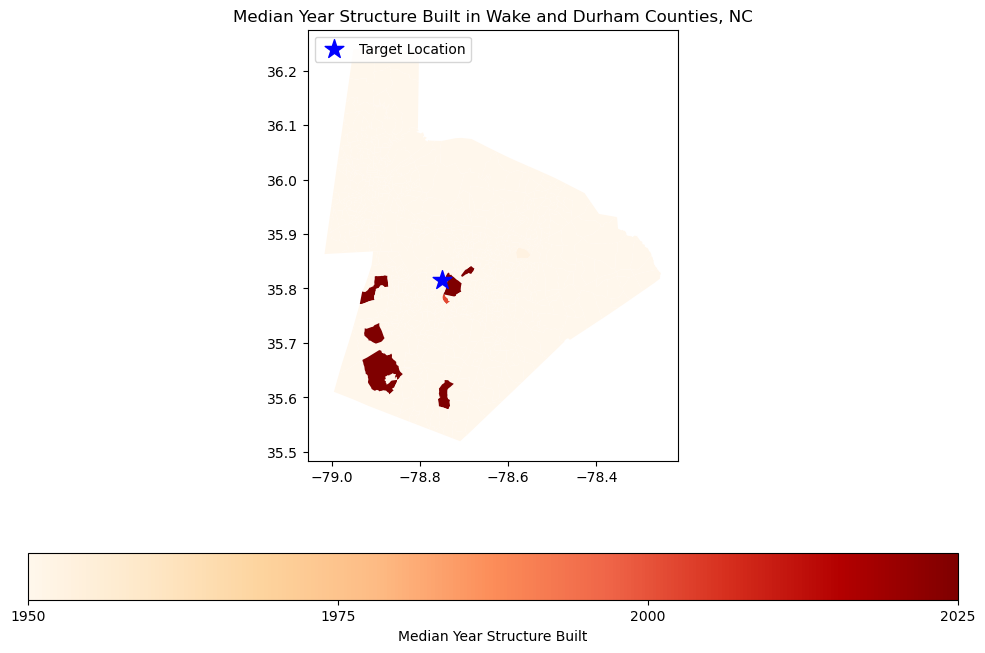

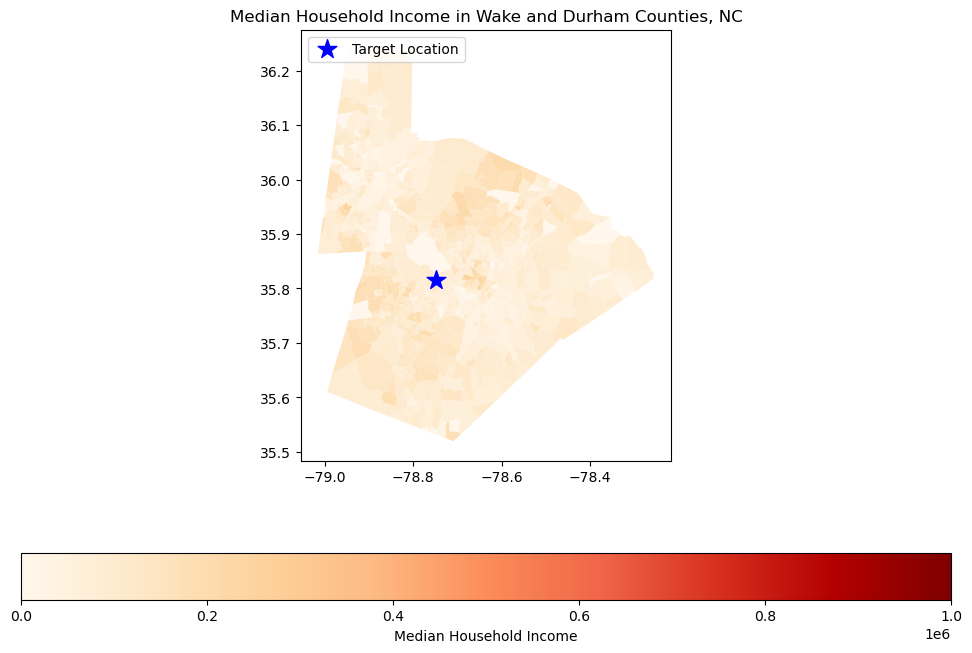

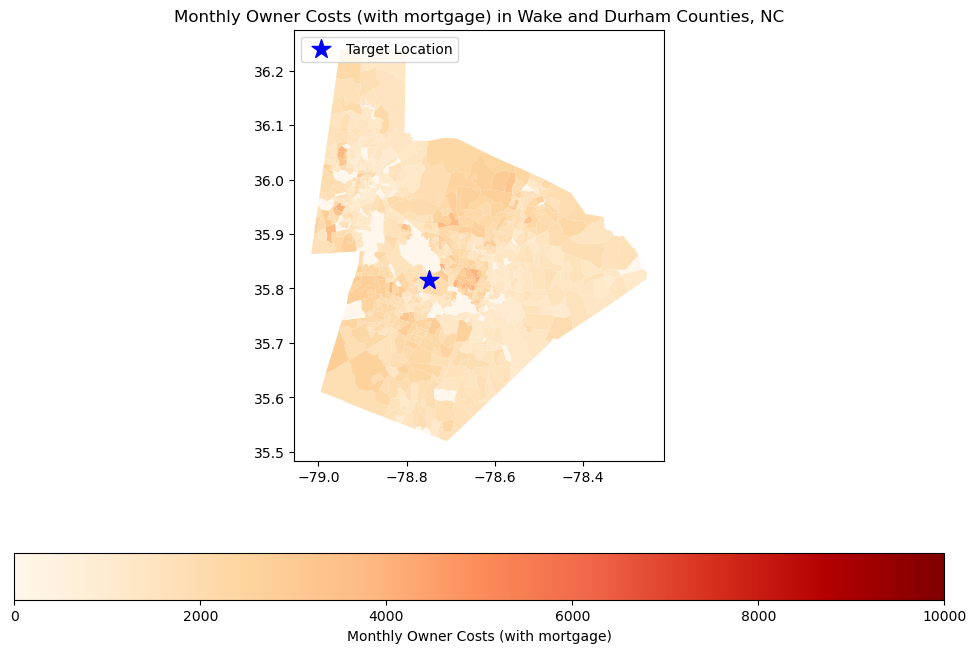

In [24]:
# Define the variables and corresponding labels/titles
variables = {
    '% Households with Children under 6': 'Percentage of Households with Children under 6',
    'Median Housing Value': 'Median Housing Value',
    'Median Year Structure Built': 'Median Year Structure Built',
    'Median Household Income': 'Median Household Income',
    'Monthly Owner Costs (with mortgage)': 'Monthly Owner Costs (with mortgage)'
}

# Define custom bounds and ticks for each variable
custom_scales = {
    '% Households with Children under 6': {'vmin': 0, 'vmax': 100, 'ticks': np.arange(0, 101, 25)},
    'Median Housing Value': {'vmin': 0, 'vmax': 1500000, 'ticks': np.arange(0, 1500001, 250000)},
    'Median Year Structure Built': {'vmin': 1950, 'vmax': 2025, 'ticks': np.arange(1950, 2026, 25)},
    'Median Household Income': {'vmin': 0, 'vmax': 1000000, 'ticks': np.arange(0, 1000001, 200000)},
    'Monthly Owner Costs (with mortgage)': {'vmin': 0, 'vmax': 10000, 'ticks': np.arange(0, 10001, 2000)}
}

# Specify the location for the star (latitude and longitude)
star_location = (-78.74939336654782, 35.81563890659871)  # From LHG's office

# Loop through the variables and create plots
for var, label in variables.items():
    # Get custom scale settings for the variable
    scale = custom_scales.get(var, {})
    vmin, vmax = scale.get('vmin'), scale.get('vmax')
    ticks = scale.get('ticks')
    
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Plot the data
    merged_gdf.plot(column=var, cmap='OrRd', legend=True, vmin=vmin, vmax=vmax,
                    legend_kwds={'label': label, 
                                 'orientation': "horizontal", 
                                 'ticks': ticks}, ax=ax)
    
    # Add the star marker
    ax.scatter(star_location[0], star_location[1], color='blue', marker='*', s=200, label='Target Location')
    
    # Add title and customize
    ax.set_title(f'{label} in Wake and Durham Counties, NC')
    ax.legend(loc='upper left')  # Add a legend for the star
    
    # Show the plot
    plt.show()

## Calculate Distance from Office

In [25]:
# Office location (latitude, longitude)
office_coords = (35.81563890659871, -78.74939336654782)

# Step 1: Re-project to a Projected CRS for accurate centroid calculations
merged_gdf = merged_gdf.to_crs(epsg=32119)  # NAD83 / North Carolina (projected CRS)

# Step 2: Calculate centroids in the projected CRS
merged_gdf['centroid'] = merged_gdf.geometry.centroid

# Step 3: Create a new GeoDataFrame for centroids and re-project to Geographic CRS
centroids_geo = merged_gdf.copy()
centroids_geo = centroids_geo.set_geometry('centroid')  # Set centroids as the active geometry
centroids_geo = centroids_geo.to_crs(epsg=4326)         # Re-project to WGS84 (latitude/longitude)

# Step 4: Extract latitude and longitude from re-projected centroids
centroids_geo['centroid_lat_lon'] = centroids_geo.geometry.apply(lambda point: (point.y, point.x))

# Debug: Check the centroid latitude and longitude
print(centroids_geo[['centroid_lat_lon']].head())

# Step 5: Calculate distances to the office in miles
centroids_geo['Distance to Office (miles)'] = centroids_geo['centroid_lat_lon'].apply(
    lambda coords: geodesic(coords, office_coords).miles
)

# Step 6: Calculate travel time assuming an average speed of 35 mph
average_speed_mph = 35
centroids_geo['Travel Time to Office (minutes)'] = centroids_geo['Distance to Office (miles)'] / average_speed_mph * 60

# Step 7: Preview the results
print(centroids_geo[['GEOID', 'Distance to Office (miles)', 'Travel Time to Office (minutes)']].head())


                           centroid_lat_lon
0  (35.903340796063844, -78.97281862215833)
1   (35.88311792466788, -78.95813687853575)
2   (36.00591132639148, -78.81109552937917)
3  (35.962512460935805, -78.82855376454891)
4   (35.92500813432616, -78.94154598109864)
          GEOID  Distance to Office (miles)  Travel Time to Office (minutes)
0  370630020191                   13.921308                        23.865100
1  370630020201                   12.606907                        21.611840
2  370630018061                   13.567275                        23.258186
3  370630018082                   11.057359                        18.955473
4  370630020241                   13.157935                        22.556460


In [26]:
# Step 8: Merge distance and travel time calculations back onto the original DataFrame
merged_gdf = merged_gdf.merge(
    centroids_geo[['GEOID', 'Distance to Office (miles)', 'Travel Time to Office (minutes)']],
    on='GEOID',
    how='left'
)

# Debug: Preview the updated merged_gdf
print(merged_gdf[['GEOID', 'Distance to Office (miles)', 'Travel Time to Office (minutes)']].head())

          GEOID  Distance to Office (miles)  Travel Time to Office (minutes)
0  370630020191                   13.921308                        23.865100
1  370630020201                   12.606907                        21.611840
2  370630018061                   13.567275                        23.258186
3  370630018082                   11.057359                        18.955473
4  370630020241                   13.157935                        22.556460


## Neighborhood Amenities

In [27]:
import osmnx as ox
import geopandas as gpd

# Step 1: Ensure the GeoDataFrame has valid geometries
print("Validating block group geometries...")
merged_gdf = merged_gdf.to_crs(epsg=4326)  # Ensure CRS is set to EPSG:4326
print(merged_gdf.geometry.head())          # Debug: Check geometries

# Step 2: Define the study area boundary
print("Creating study area boundary...")
study_area_boundary = merged_gdf.geometry.union_all()  # Combine all block group geometries
print("Study area boundary created.")

# Step 3: Query all amenities in the study area
print("Fetching OSM data for the entire study area...")
amenity_queries = {
    'grocery_store': {
        'amenity': ['supermarket', 'convenience', 'grocery'],  # Grocery-specific tags
        'shop': ['department_store', 'wholesale']             # General retail and wholesale
    },
    'park': {'leisure': 'park'},
    'bike_trail': {'highway': 'cycleway'}
}

# Store fetched data in a dictionary
amenity_data = {}
for amenity, tags in amenity_queries.items():
    print(f"Fetching {amenity}...")
    try:
        # Fetch OSM data for the entire study area boundary
        amenity_data[amenity] = ox.features_from_polygon(study_area_boundary, tags)
        print(f"Fetched {len(amenity_data[amenity])} features for {amenity}.")
    except Exception as e:
        print(f"Error fetching {amenity}: {e}")
        amenity_data[amenity] = gpd.GeoDataFrame()

# Step 4: Check for intersections with each block group
print("Checking intersections with block groups...")
for amenity, amenities_gdf in amenity_data.items():
    if not amenities_gdf.empty:
        # Ensure amenities GeoDataFrame has a valid CRS
        amenities_gdf = amenities_gdf.set_crs(epsg=4326, allow_override=True)
    
        # Add indicator column to the block groups GeoDataFrame
        print(f"Processing intersections for {amenity}...")
        merged_gdf[f'has_{amenity}'] = merged_gdf.geometry.apply(
            lambda geom: 1 if not amenities_gdf[amenities_gdf.intersects(geom.buffer(0.001))].empty else 0
        )
    else:
        print(f"No data found for {amenity}.")
        # If no amenities were found in the study area, set all values to 0
        merged_gdf[f'has_{amenity}'] = 0

# Step 5: Preview the resulting DataFrame
print(merged_gdf[['GEOID', 'has_grocery_store', 'has_park', 'has_bike_trail']].head())

Validating block group geometries...
0    POLYGON ((-78.98415 35.91174, -78.98394 35.911...
1    POLYGON ((-78.97849 35.86682, -78.97764 35.867...
2    POLYGON ((-78.82221 35.99619, -78.82158 35.999...
3    POLYGON ((-78.84645 35.96563, -78.84617 35.965...
4    POLYGON ((-78.95244 35.9226, -78.9524 35.92261...
Name: geometry, dtype: geometry
Creating study area boundary...
Study area boundary created.
Fetching OSM data for the entire study area...
Fetching grocery_store...


/opt/conda/lib/python3.10/site-packages/osmnx/features.py:690: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  gdf.loc[:, "geometry"] = gdf["geometry"].make_valid()


Fetched 97 features for grocery_store.
Fetching park...


/opt/conda/lib/python3.10/site-packages/osmnx/features.py:690: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  gdf.loc[:, "geometry"] = gdf["geometry"].make_valid()


Fetched 730 features for park.
Fetching bike_trail...


/opt/conda/lib/python3.10/site-packages/osmnx/features.py:690: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  gdf.loc[:, "geometry"] = gdf["geometry"].make_valid()


Fetched 5966 features for bike_trail.
Checking intersections with block groups...
Processing intersections for grocery_store...
Processing intersections for park...
Processing intersections for bike_trail...
          GEOID  has_grocery_store  has_park  has_bike_trail
0  370630020191                  0         0               0
1  370630020201                  0         0               1
2  370630018061                  0         0               0
3  370630018082                  0         1               0
4  370630020241                  0         0               1


## Export Data

In [28]:
# Step 1: Ensure the GeoDataFrame has a valid CRS (EPSG:4326 for SAS compatibility)
merged_gdf = merged_gdf.to_crs(epsg=4326)

# Step 2: Save the GeoDataFrame as a CAS table
# Replace "casuser" with the name of your CAS library if needed
merged_gdf.to_csv("operation_new_nest.csv", index=False)  # Save as CSV
